In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse

plt.style.use(['grid', 'science', 'notebook', 'mylegend'])

In [3]:
data_dir = 'data'

# Load the train data

In [4]:
train_data = pd.read_csv(f"{data_dir}/train_data.csv", encoding="utf8")
train_data.head()

,author,subreddit,created_utc,body
0,Shamus_Aran,mylittlepony,1.388534e+09,I don't think we'd get nearly as much fanficti...
1,Riddance,sex,1.388534e+09,"Thanks. I made it up, that's how I got over my..."
2,Secret_Wizard,DragonsDogma,1.388534e+09,Are you sure you aren't confusing Cyclops (the...
3,Penultimatum,malefashionadvice,1.388534e+09,dont do this to me bro
4,7-SE7EN-7,todayilearned,1.388534e+09,That's what we do when we can't find a mate


In [5]:
train_data.author.unique().shape

(5000,)

In [6]:
target = pd.read_csv(f"{data_dir}/train_target.csv", encoding="utf8")
target.head()  # 1 - male; 0 - female

,author,gender
0,RedThunder90,0
1,Lirkmor,1
2,In0chi,0
3,ProjectGrudge,0
4,TehTurtleHermit,0


# Feature Extraction

In [7]:
subreddits = train_data.subreddit.unique()
# subreddits_map is a series that associates a subreddit with an index
# why this is absolutely necessary is still unclear
subreddits_map = pd.Series(index=subreddits, data=np.arange(subreddits.shape[0]))

In [8]:
def extract_features(group: pd.DataFrame) -> sparse.csr_matrix:
    """
    This function converts all the subreddits the author has posted in into a 1xN sparse
    matrix (where N is the number of subreddits in the dataset) with 1s in the indexes
    of the subreddits the author has posted in.
    """
    # this basically converts group['subreddit'] to an array of subreddits
    # why on earth it is done like this is beyond me
    group_subreddits = group['subreddit']
    group_subreddits = group_subreddits[group_subreddits.isin(subreddits_map.index)].values

    # idxs is an array with the indexes of the subreddits in the subreddits_map
    idxs = subreddits_map.loc[group_subreddits].values

    # create a sparse matrix with 1s in the indexes of the subreddits the author has posted in
    v = sparse.dok_matrix((1, len(subreddits))) # dok = dictionary of keys; why not use dok_array?
    for idx in idxs:
        if not np.isnan(idx):  # is this really necessary?
            v[0, idx] = 1
    return v.tocsr()  # convert to compressed sparse row format

extract_features(train_data[train_data.author=='RedThunder90'])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1 stored elements and shape (1, 3468)>

In [9]:
# Create a dictionary mapping the author to the sparse matrix of subreddits they have
# posted in

features_dict: dict[str, pd.DataFrame] = {}

for author, group in train_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [10]:
# Generate a sparse matrix with the labelled authors as rows and the subreddits they
# have posted in as columns

X = sparse.vstack([features_dict[author] for author in target.author])
X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 49152 stored elements and shape (5000, 3468)>

In [11]:
y = target.gender

In [12]:
def extract_text(group: pd.DataFrame) -> str:
    """
    Concatenates all the posts of an author into a single string.
    """
    group_text = group['body'].astype(str).values
    return " ".join(group_text)

extract_text(train_data[train_data.author == "RedThunder90"])

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

In [13]:
# Create a dictionary mapping the author to the text of all their posts

text_dict: dict[str, str] = {}

for author, group in train_data.groupby('author'):
    text_dict[author] = extract_text(group)

In [14]:
# Generate a list with the labelled authors as indexes and the text of all their posts
# in the respective position

author_text = [text_dict[author] for author in target.author]
author_text[0]

'I still prefer to buy foods either grown locally or where animals are treated better, but this definitely has me looking at organic food differently.'

At this point I have three data structures:
- `X`: a sparse matrix N_authors x N_subreddits linking all the authors with the subreddits they have posted in
- `author_text`: a list of length N_authors containing in position i all the text posted by author i
- `y`: a pandas series containing the gender of the authors

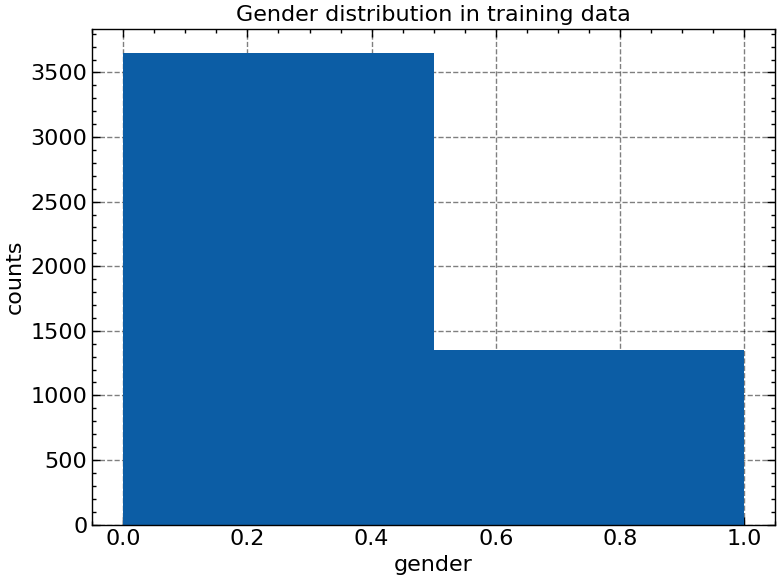

In [15]:
fig, ax = plt.subplots(1, 1)
y.hist(bins=2, ax=ax)

ax.set_title('Gender distribution in training data')
ax.set_xlabel('gender')
ax.set_ylabel('counts')

fig.tight_layout()
plt.show()

# Model Selection

In [16]:
import sklearn
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
class RandomModel():
    '''Random model'''
    def predict_proba(self, X):
        return np.random.random((X.shape[0], 2))

random_model = RandomModel()

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Support Vector  Classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from collections import OrderedDict

models = OrderedDict([
          ('Knn 1', KNeighborsClassifier(n_neighbors=1)),
          ('Knn 5', KNeighborsClassifier(n_neighbors=5)),
          ('Knn 9', KNeighborsClassifier(n_neighbors=9)),
          ('Naive Bayes', GaussianNB()),
          ('LogReg', LogisticRegression()),
        #   ('Linear SVM', SVC(kernel='linear', probability=True)),          # SVC con kernel lineare
        #   ('Poly SVM', SVC(kernel='poly', degree=2, probability=True)),    # SVC con kernel polinomiale
        #   ('RBF SVM', SVC(kernel='rbf', gamma=2, C=1, probability=True)),  # SVC con kernel boh
          ('Class Tree', DecisionTreeClassifier(max_depth=5)),
        #   ('Random Forest', RandomForestClassifier(max_depth=5, n_estimators=50)),  # parametri: max_depth degli alberi, n_alberi
          ('Multi Perc', MLPClassifier(hidden_layer_sizes=(4,3,2), activation='tanh', solver='adam', max_iter=10_000,
                                                  learning_rate_init=0.01, random_state=0))
          ])

In [20]:
X_train = X_train.toarray()
X_val = X_val.toarray()

Training Knn 1       -- ROC AUC: 0.63, score: 0.70
Training Knn 5       -- ROC AUC: 0.67, score: 0.72
Training Knn 9       -- ROC AUC: 0.61, score: 0.76
Training Naive Bayes -- ROC AUC: 0.71, score: 0.65
Training LogReg      -- ROC AUC: 0.76, score: 0.86
Training Class Tree  -- ROC AUC: 0.65, score: 0.80
Training Multi Perc  -- ROC AUC: 0.77, score: 0.83


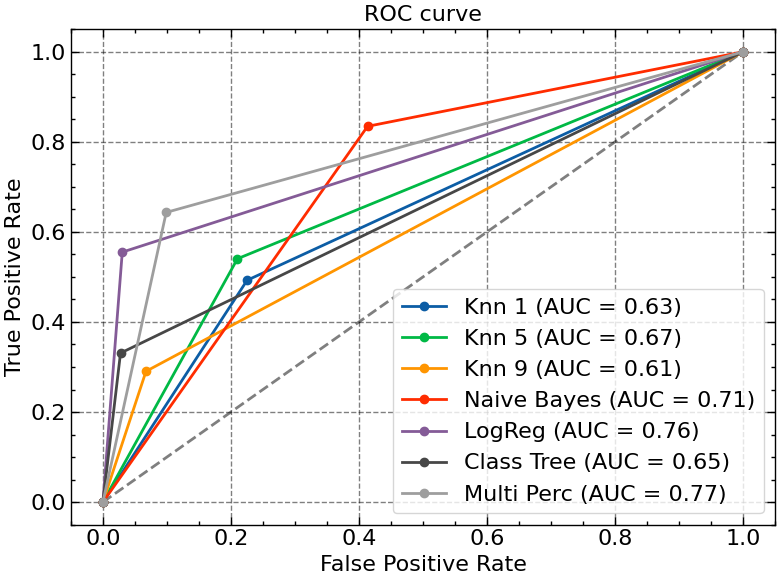

In [21]:
model_rocs: dict[str, float] = {}
model_scores: dict[str, float] = {}

fig, ax = plt.subplots(1, 1)
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5)  # null model ROC curve

ax.set_title('ROC curve')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
for name, model in models.items():
    print(f"Training {name:<11}", end=' -- ')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_val)  # the exercise says to use predict_proba, but predict is used here
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_val, y_pred)
    roc_auc = sklearn.metrics.roc_auc_score(y_val, y_pred)
    model_rocs[name] = roc_auc

    score = model.score(X_val, y_val)
    model_scores[name] = score

    print(f"ROC AUC: {roc_auc:.2f}, score: {score:.2f}")

    ax.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})", marker='o')

ax.legend()

fig.tight_layout()
plt.show()

# Performance metrics

In [22]:
def roc_curve(y_pred, y_true) -> float:
    false_positive_rate, true_positive_rate, _ = sklearn.metrics.roc_curve(y_true, y_pred)
    fig, ax = plt.subplots(1, 1)
    ax.plot(false_positive_rate, true_positive_rate)
    # ax.axhline(1, color='black', linestyle='--', xmin=0.05, xmax=0.95)
    # ax.axvline(1, color='black', linestyle='--', ymin=0.05, ymax=0.95)

    ax.plot(false_positive_rate, false_positive_rate, linestyle='--', color='black')
    
    ax.set_title('ROC curve')
    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    fig.tight_layout()
    plt.show()

    return sklearn.metrics.roc_auc_score(y_true, y_pred)

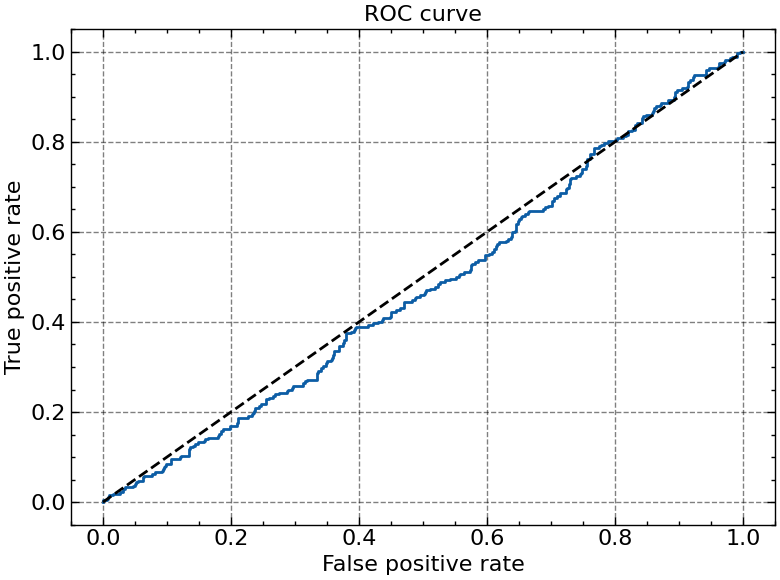

ROC AUD score: 0.479


In [23]:
y_pred = random_model.predict_proba(X_val)[:,1]

print(f"ROC AUD score: {roc_curve(y_pred, y_val):.3f}")

# Prepare the solution

In [24]:
test_data = pd.read_csv(f"{data_dir}/test_data.csv", encoding="utf8")

In [25]:
features_dict: dict[str, pd.DataFrame] = {}

for author, group in test_data.groupby('author'):
    features_dict[author] = extract_features(group)

In [26]:
X_test = sparse.vstack([features_dict[author] for author in test_data.author.unique()])
X_test

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 144898 stored elements and shape (15000, 3468)>

In [27]:
text_dict = {}

for author, group in test_data.groupby('author'):
    text_dict[author] = extract_text(group)

In [28]:
author_text_test = [text_dict[author] for author in test_data.author.unique()]

In [29]:
author_text_test[0][:100]

"I hadn't ever heard of them before joining this subreddit. They're not really a big thing in the US,"

In [30]:
y_pred = model.predict_proba(X_test)[:,1]

In [31]:
solution = pd.DataFrame({"author": test_data.author.unique(), "gender": y_pred})
solution.head()

,author,gender
0,ejchristian86,0.989898
1,ZenDragon,0.004458
2,savoytruffle,0.004458
3,hentercenter,0.004461
4,rick-o-suave,0.237077


In [32]:
solution.to_csv("submission.csv", index=False)

Now go to [Kaggle](https://www.kaggle.com/competitions/datamining2024/overview), click "Submit Prediction" and upload the file "submission.csv" to see the test score.